In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset,Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle

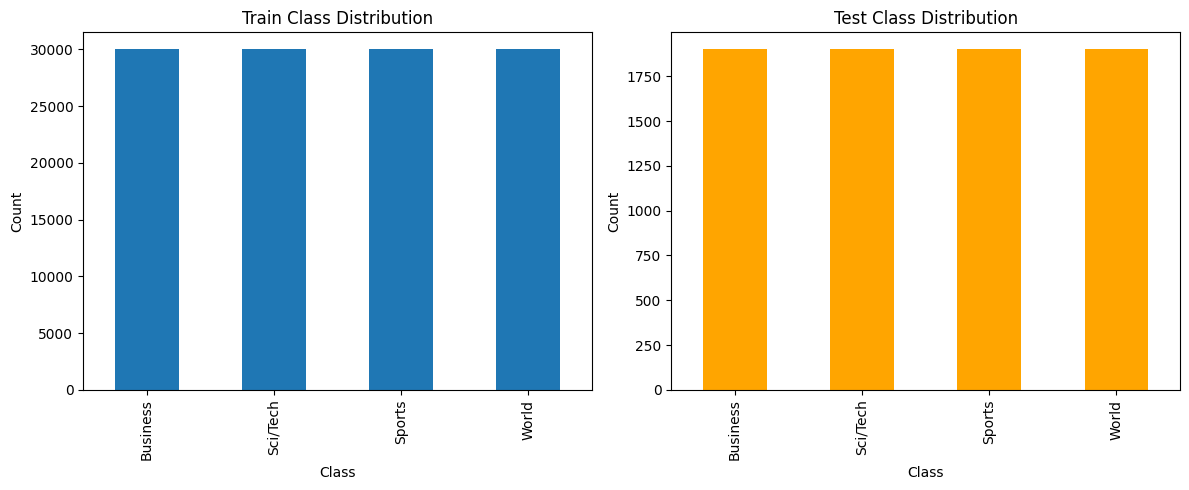

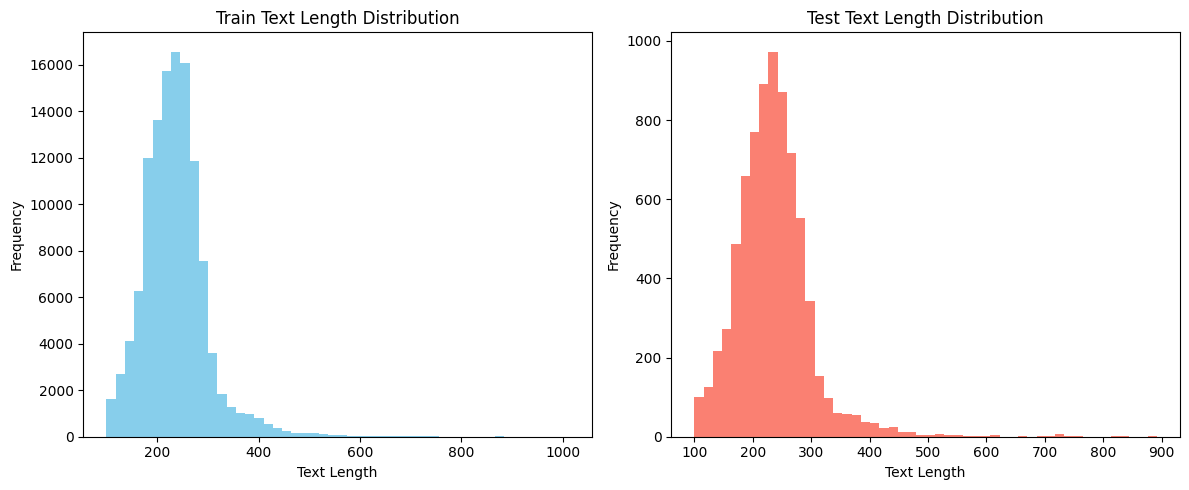

In [2]:
dataset = load_dataset("ag_news")

df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])

df_train["text_length"] = df_train["text"].apply(len)
df_test["text_length"] = df_test["text"].apply(len)

label_names = dataset["train"].features["label"].names
df_train["label_name"] = df_train["label"].apply(lambda x: label_names[x])
df_test["label_name"] = df_test["label"].apply(lambda x: label_names[x])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_train["label_name"].value_counts().plot(kind="bar", title="Train Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
df_test["label_name"].value_counts().plot(kind="bar", title="Test Class Distribution", color='orange')
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df_train["text_length"], bins=50, color='skyblue')
plt.title("Train Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(df_test["text_length"], bins=50, color='salmon')
plt.title("Test Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [3]:
# Print 2 examples per label
for label_id, label_name in enumerate(label_names):
    print(f"\n--- {label_name.upper()} (Label {label_id}) ---")
    samples = df_train[df_train["label"] == label_id]["text"].head(2).tolist()
    for i, text in enumerate(samples, 1):
        print(f"{i}. {text}\n")


--- WORLD (Label 0) ---
1. Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to govern for the next two\years.

2. S.Koreans Clash with Police on Iraq Troop Dispatch (Reuters) Reuters - South Korean police used water cannon in\central Seoul Sunday to disperse at least 7,000 protesters\urging the government to reverse a controversial decision to\send more troops to Iraq.


--- SPORTS (Label 1) ---
1. Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had been added to the American team for the evening's 400 freestyle relay final. Phelps' rivals Ian Thorpe and Pieter van den Hoogenband and teammate Klete Keller were faster than the teenager in the 200 free preliminarie

In [4]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [5]:
# Load RoBERTa base model
base_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

# Apply LoRA config
peft_config = LoraConfig(
    r=4,
    lora_alpha=16,
    lora_dropout=0,
    bias='none',
    target_modules=["query", "value"],
    task_type="SEQ_CLS",
)
model = get_peft_model(base_model, peft_config)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 741124


In [6]:
training_args = TrainingArguments(
    output_dir="./results",
    report_to=None,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_strategy='epoch',
    learning_rate=4e-4,
    num_train_epochs=5,
    warmup_steps=100,
    lr_scheduler_type="cosine",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=2,
    optim="adamw_torch",
    dataloader_num_workers=4,
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant': True},
)

# Loss function with label smoothing
loss_fct = nn.CrossEntropyLoss(label_smoothing=0.1)

In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.534300,0.483303,0.933421
2,0.473100,0.464941,0.941184
3,0.459000,0.461563,0.944605
4,0.447900,0.457180,0.946184
5,0.442800,0.455971,0.947105


TrainOutput(global_step=9375, training_loss=0.4714255143229167, metrics={'train_runtime': 3942.4003, 'train_samples_per_second': 152.192, 'train_steps_per_second': 2.378, 'total_flos': 3.98088769536e+16, 'train_loss': 0.4714255143229167, 'epoch': 5.0})

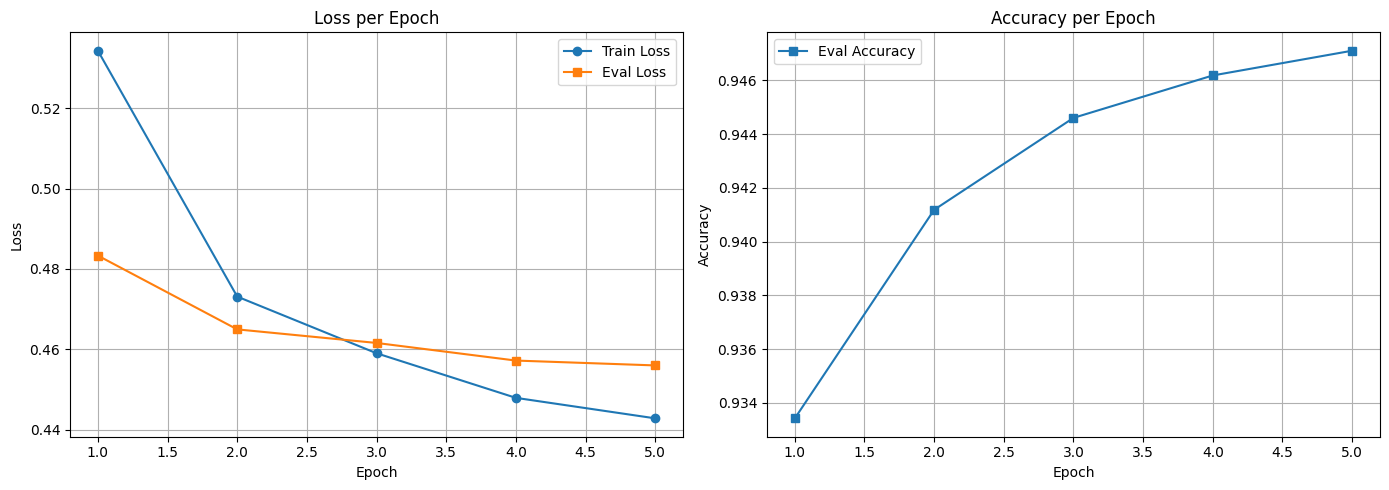

In [8]:
# Convert logs to DataFrame
logs = trainer.state.log_history
log_df = pd.DataFrame(logs)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss: training + evaluation
if "loss" in log_df.columns:
    train_loss = log_df[["epoch", "loss"]].dropna()
    ax[0].plot(train_loss["epoch"], train_loss["loss"], label="Train Loss", marker="o")

if "eval_loss" in log_df.columns:
    eval_loss = log_df[["epoch", "eval_loss"]].dropna()
    ax[0].plot(eval_loss["epoch"], eval_loss["eval_loss"], label="Eval Loss", marker="s")

ax[0].set_title("Loss per Epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True)

if "eval_accuracy" in log_df.columns:
    eval_acc = log_df[["epoch", "eval_accuracy"]].dropna()
    ax[1].plot(eval_acc["epoch"], eval_acc["eval_accuracy"], label="Eval Accuracy", marker="s")

if "accuracy" in log_df.columns:
    train_acc = log_df[["epoch", "accuracy"]].dropna()
    ax[1].plot(train_acc["epoch"], train_acc["accuracy"], label="Train Accuracy", marker="o")

ax[1].set_title("Accuracy per Epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

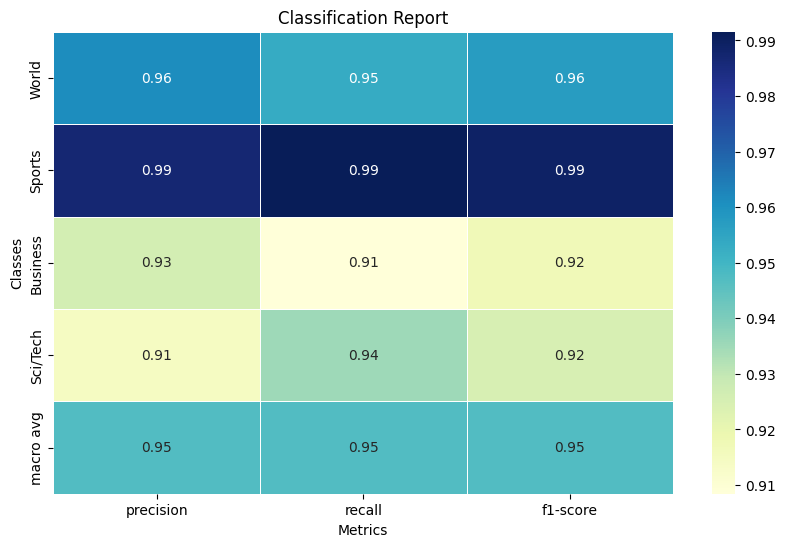

In [9]:
preds = trainer.predict(dataset["test"])
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=-1)

label_names = dataset["train"].features["labels"].names
report_dict = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

report_df = report_df.drop(['accuracy'], errors='ignore')

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title("Classification Report")
plt.ylabel("Classes")
plt.xlabel("Metrics")
plt.show()


In [10]:
eval_results = trainer.evaluate()
print("Final Evaluation Accuracy:", eval_results["eval_accuracy"])

Final Evaluation Accuracy: 0.9471052631578948


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open("test_unlabelled.pkl", "rb") as f:
    test_dataset = pickle.load(f)

test_dataset = Dataset.from_dict({"text": test_dataset["text"]})

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

test_dataloader = DataLoader(tokenized_test_dataset, batch_size=64)

model.eval()
all_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_predictions.extend(preds.cpu().numpy())

Map: 100%|██████████| 8000/8000 [00:00<00:00, 12608.86 examples/s]


In [14]:
df = pd.DataFrame({
    "ID": list(range(len(all_predictions))),
    "label": all_predictions
})
df.to_csv("submission_7.csv", index=False)
print("Batched predictions complete. Saved to submission_7.csv.")

Batched predictions complete. Saved to submission_7.csv.
